DATA LOADING AND PREPARATION

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

# SFOAE data loading
mat_SFOAE = scipy.io.loadmat('data/SFOAE/sfoae20dBg130TM45R19rs2.mat')

freq_SFOAE = mat_SFOAE['Fvect'].flatten()  # frequency axis
SFOAE = mat_SFOAE['oaeNum20'].flatten()  # SFOAE wave
CRcomp = mat_SFOAE['CRc20'].flatten()  # CR component
NLcomp = mat_SFOAE['Yunl20'].flatten()  # NL component

# unwrapped phase of the SFOAE wave
phase_unwrap_SFOAE = np.unwrap(np.angle(SFOAE))


CEPSTRUM ANALYSIS ALGORITHM

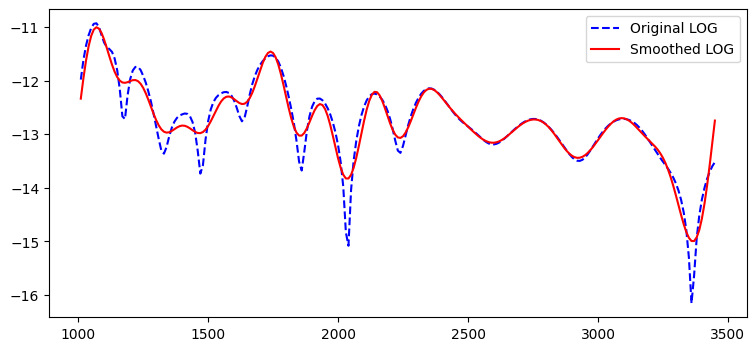

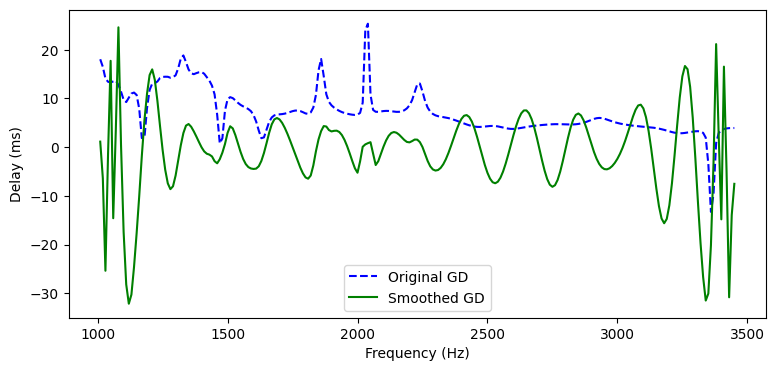

In [67]:
from scipy.signal import savgol_filter
from cutoff_window import *

# smoothing the phase with a Savitzky-Golay filter
smoothed_phase = savgol_filter(phase_unwrap_SFOAE, 5, 1)
# smoothing is necessary here to render the transformation monotonic
# the minus sign then guarantees that phi increases with f
phi = -smoothed_phase/(2*np.pi)

# calculation of the number of cycles travelled by phi
dphi = np.diff(phi)
sign_changes = np.sign(dphi[1:]) - np.sign(dphi[:-1])
# phi is already in cycles (no need to divide by 2pi) or is it required ???
# N_cycles = np.round(np.max(phi) - np.min(phi))
N_cycles = np.count_nonzero(sign_changes)

# calculate phi (normalized phase) with respect to frequency
# freq_phi = np.fft.fftfreq(len(phi))

# calculate logarithm of SFOAE and perform FFT with respect to phi
log_SFOAE = np.log(SFOAE)  # = np.log(np.abs(SFOAE)) + 1j*phase_unwrap_SFOAE
# log_SFOAE_reshaped = log_SFOAE.reshape((1, -1))
# fft_log_SFOAE_phi = np.fft.fft(log_SFOAE_reshaped + 2*np.pi*1j*phi, axis=1)
fft_log_SFOAE_phi = np.fft.fft(log_SFOAE + 2*np.pi*1j*phi)
# fft_log_SFOAE_phi = np.squeeze(fft_log_SFOAE_phi)

# obtain the quefrency axis
delta_phi = np.mean(np.abs(np.diff(phi))) # taking the average (phi is a complex-valued variable)
phi_linspace = np.linspace(phi[0], phi[-1], np.size(phi))
delta_phi_lin = phi_linspace[1] - phi_linspace[0] # step size between phi values
quefrency = np.fft.fftfreq(np.size(phi_linspace), d=delta_phi_lin) # sampling frequency d
# quefrency = np.fft.fftfreq(len(fft_log_SFOAE_phi))

# cutoff window
eta_c = 0.9*N_cycles  # quefrency cutoff
smooth_order = 10  # order of the smoothing function
window = getWindow(quefrency, eta_c, smooth_order) # cutoff window

# apply the window function to the FFT output in order to cutoff at eta_c quefrency
fft_log_SFOAE_phi = np.multiply(window, fft_log_SFOAE_phi)
# obtaining the smoothed signal
log_0_SFOAE = np.fft.ifft(fft_log_SFOAE_phi) - 2*np.pi*1j*phi

fig, ax = plt.subplots(figsize=(9, 4))
# ax.plot(freq_SFOAE, np.log10(np.exp(log_SFOAE)), "g", label="Original LOG10")
ax.plot(freq_SFOAE, log_SFOAE, "b--", label="Original LOG")
ax.plot(freq_SFOAE, log_0_SFOAE, "r", label="Smoothed LOG")
plt.legend()
plt.show()

phase_unwrap_SFOAE = np.unwrap(np.angle(SFOAE))
phase_grad_SFOAE = np.gradient(phase_unwrap_SFOAE, freq_SFOAE)
group_delay_SFOAE = -phase_grad_SFOAE/(2*np.pi)

smooth_SFOAE = np.exp(log_0_SFOAE)
smooth_phase = np.unwrap(np.angle(smooth_SFOAE))
grad_smooth = np.gradient(smooth_phase, freq_SFOAE)
smooth_GD = -grad_smooth/(2*np.pi)

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(freq_SFOAE, 1000*group_delay_SFOAE, "b--", label = "Original GD")
ax.plot(freq_SFOAE, 1000*smooth_GD, "g", label="Smoothed GD")
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Delay (ms)")
plt.show()


RESULTS DISPLAYING

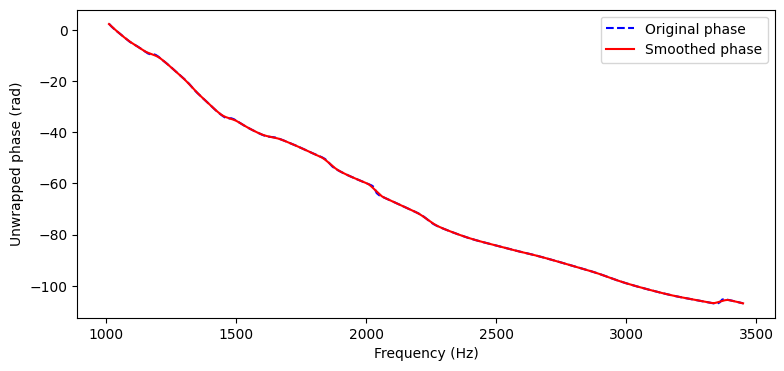

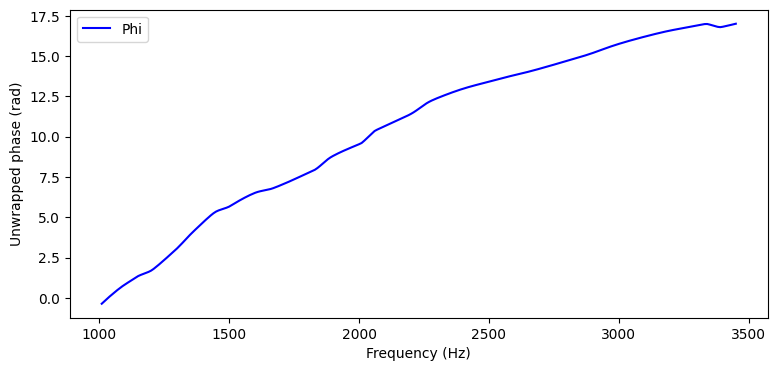

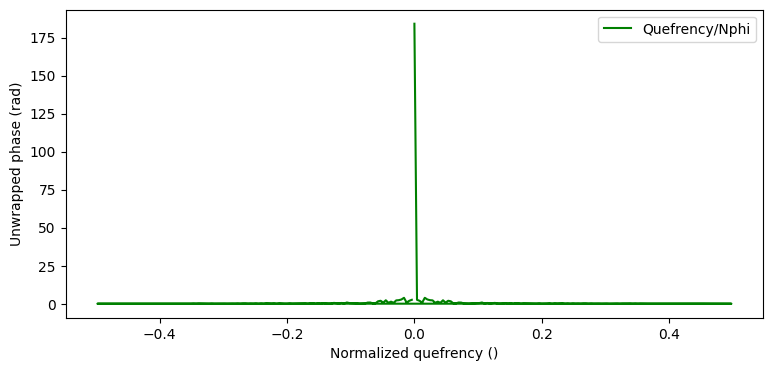

In [12]:
fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(freq_SFOAE, phase_unwrap_SFOAE, "b--", label="Original phase")
ax.plot(freq_SFOAE, smoothed_phase, "r", label="Smoothed phase")
# ax.set_xscale('log')
# ax.set_xlim([1000, 3.5e3])
# ax.set_ylim([0, 20])
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Unwrapped phase (rad)')
ax.legend()
# ax.set_title('Group delay 20 dB')
plt.show()

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(freq_SFOAE, phi, "b", label="Phi")
# ax.set_xscale('log')
# ax.set_xlim([1000, 3.5e3])
# ax.set_ylim([0, 20])
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Unwrapped phase (rad)')
ax.legend()
# ax.set_title('Group delay 20 dB')
plt.show()

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(freq_phi, np.abs(np.fft.fft(np.real(np.log(SFOAE)))) /
        N_cycles, "g", label="Quefrency/Nphi")
# ax.set_xscale('log')
# ax.set_xlim([1000, 3.5e3])
# ax.set_ylim([0, 20])
ax.set_xlabel('Normalized quefrency ()')
ax.set_ylabel('Unwrapped phase (rad)')
ax.legend()
# ax.set_title('Group delay 20 dB')
plt.show()


EXPERIMENT